Quick tutorial to explain how to create a environment with braitenberg vehicles equiped with selective sensors (still a draft so comments of the notebook won't be complete yet)

In [9]:
import logging as lg

from enum import Enum
from functools import partial
from typing import Tuple

import jax
import numpy as np
import jax.numpy as jnp

from jax import vmap, jit
from jax import random, ops, lax

from flax import struct
from jax_md.rigid_body import RigidBody
from jax_md import simulate 
from jax_md import space, rigid_body, partition, quantity

from vivarium.experimental.environments.utils import normal, distance 
from vivarium.experimental.environments.base_env import BaseState, BaseEnv
from vivarium.experimental.environments.physics_engine import total_collision_energy, friction_force, dynamics_fn
from vivarium.experimental.environments.braitenberg.simple import relative_position, proximity_map, sensor_fn, sensor
from vivarium.experimental.environments.braitenberg.simple import Behaviors, behavior_to_params, linear_behavior
from vivarium.experimental.environments.braitenberg.simple import lr_2_fwd_rot, fwd_rot_2_lr, motor_command
from vivarium.experimental.environments.braitenberg.simple import braintenberg_force_fn

In [10]:
# Used for jax.debug.breakpoint in a jupyter notebook
class FakeStdin:
  def readline(self):
    return input()
  
# Usage : 
# jax.debug.breakpoint(backend="cli", stdin=FakeStdin())

# See this issue : https://github.com/google/jax/issues/11880

## Create the classes and helper functions

Add entity sensed type as a field in entities + sensed in agents. The agents sense the "sensed type" of the entities. In our case, there will be preys, predators, ressources and poison.

In [11]:

### Define the constants and the classes of the environment to store its state ###
SPACE_NDIMS = 2

class EntityType(Enum):
    AGENT = 0
    OBJECT = 1

class EntitySensedType(Enum):
    PREY = 0
    PRED = 1
    RESSOURCE = 2
    POISON = 3

# Already incorporates position, momentum, force, mass and velocity
@struct.dataclass
class EntityState(simulate.NVEState):
    entity_type: jnp.array
    ent_sensed_type: jnp.array
    entity_idx: jnp.array
    diameter: jnp.array
    friction: jnp.array
    exists: jnp.array
    
@struct.dataclass
class ParticleState:
    ent_idx: jnp.array
    color: jnp.array

@struct.dataclass
class AgentState(ParticleState):
    prox: jnp.array
    motor: jnp.array
    proximity_map_dist: jnp.array
    proximity_map_theta: jnp.array
    behavior: jnp.array
    params: jnp.array
    sensed: jnp.array
    wheel_diameter: jnp.array
    speed_mul: jnp.array
    max_speed: jnp.array
    theta_mul: jnp.array    
    proxs_dist_max: jnp.array
    proxs_cos_min: jnp.array

@struct.dataclass
class ObjectState(ParticleState):
    pass

@struct.dataclass
class State(BaseState):
    max_agents: jnp.int32
    max_objects: jnp.int32
    neighbor_radius: jnp.float32
    dt: jnp.float32  # Give a more explicit name
    collision_alpha: jnp.float32
    collision_eps: jnp.float32
    entities: EntityState
    agents: AgentState
    objects: ObjectState    

Define get_relative_displacement

In [12]:
# TODO : Add doc
def get_relative_displacement(state, agents_neighs_idx, displacement_fn):
    body = state.entities.position
    senders, receivers = agents_neighs_idx
    Ra = body.center[senders]
    Rb = body.center[receivers]
    dR = - space.map_bond(displacement_fn)(Ra, Rb)  # Looks like it should be opposite, but don't understand why

    dist, theta = proximity_map(dR, body.orientation[senders])
    proximity_map_dist = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_dist = proximity_map_dist.at[senders, receivers].set(dist)
    proximity_map_theta = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_theta = proximity_map_theta.at[senders, receivers].set(theta)
    return dist, theta, proximity_map_dist, proximity_map_theta


to compute motors, only use linear behaviors (don't vmap it) because we vmap the functions to compute agents proxiemters and motors at a higher level 


In [13]:
def compute_motor(proxs, params, behaviors, motors):
    """Compute new motor values. If behavior is manual, keep same motor values. Else, compute new values with proximeters and params.

    :param proxs: proximeters of all agents
    :param params: parameters mapping proximeters to new motor values
    :param behaviors: array of behaviors
    :param motors: current motor values
    :return: new motor values
    """
    manual = jnp.where(behaviors == Behaviors.MANUAL.value, 1, 0)
    manual_mask = manual
    linear_motor_values = linear_behavior(proxs, params)
    motor_values = linear_motor_values * (1 - manual_mask) + motors * manual_mask
    return motor_values

## 1 : Add functions to compute the proximeters and motors of agents with occlusion

Logic for computing sensors and motors: 

- We get the raw proxs
- We get the ent types of the two detected entities (left and right)
- For each behavior, we updated the proxs according to the detected and the sensed entities (e.g sensed entities = [0, 1, 0 , 0] : only sense ent of type 1)
- We then compute the motor values for each behavior and do a mean of them 

Create functions to update the two proximeter of an agent for a specific behavior 

- We already have the two closest proximeters in this case
- We want to compute the value of motors associated to a behavior for these proxs
- We can sense different type of entities 
- The two proximeters are each associated to a specific entity type
- So if the specific entity type is detected, the proximeter value is kept 
- Else it is set to 0 so it won't have effect on the motor values 
- To do so we use a mask (mask of 1's, if an entity is detected we set it to 0 with a multiplication)
- So if the mask is already set to 0 (i.e the ent is detected), the masked value will still be 0 even if you multiply it by 1
- Then we update the proximeter values with a jnp.where

In [14]:


def update_mask(mask, e_sensed_types, ent_type):
    cur = jnp.where(e_sensed_types == ent_type, 0, 1)
    mask *= cur
    return mask

def keep_mask(mask, e_sensed_types, ent_type):
    return mask

def mask_proxs_occlusion(proxs, e_sensed_types, ent_sensed_arr):
    mask = jnp.array([1, 1])
    for ent_type, sensed in enumerate(ent_sensed_arr):
        mask = jax.lax.cond(sensed, update_mask, keep_mask, mask, e_sensed_types, ent_type)
    proxs = jnp.where(mask, 0, proxs)
    return proxs

# Example :
# ent_sensed_arr = jnp.array([0, 1, 0, 0, 1])
# proxs = jnp.array([0.8, 0.2])
# e_sensed_types = jnp.array([4, 4]) # Modify these values to check it works
# print(mask_proxs_occlusion(proxs, e_sensed_types, ent_sensed_arr))

Create a function to compute the motor values for a specific behavior 

- Convert the idx of the detected entitites (associated to the values of the two proximeters) into their types
- Mask their sensors with the function presented above 
- Compute the motors with the updated sensors

In [15]:
def compute_behavior_motors(state, params, sensed_mask, behavior, motor, agent_proxs, sensed_ent_idx):
    sensed_ent_types = state.entities.ent_sensed_type[sensed_ent_idx]
    # jax.debug.print("sensed_ent_idx : {x}", x=sensed_ent_idx)
    # jax.debug.print("sensed_ent_types : {x}", x=sensed_ent_types)
    behavior_proxs = mask_proxs_occlusion(agent_proxs, sensed_ent_types, sensed_mask)
    # jax.debug.breakpoint(backend="cli", stdin=FakeStdin())
    # jax.debug.print("agent_proxs : {x}", x=agent_proxs)
    # jax.debug.print("sensed_mask : {x}", x=sensed_mask)
    # jax.debug.print("behavior_proxs : {x}", x=behavior_proxs)
    motors = compute_motor(behavior_proxs, params, behaviors=behavior, motors=motor)
    return motors

# See for the vectorizing idx because already in a vmaped function here
compute_all_behavior_motors = vmap(compute_behavior_motors, in_axes=(None, 0, 0, 0, None, None, None))

Create a function to compute the motor values each agent

In [16]:
def compute_occlusion_proxs_motors(state, agent_idx, params, sensed, behaviors, motor, raw_proxs, ag_idx_dense_senders, ag_idx_dense_receivers):
    behavior = jnp.expand_dims(behaviors, axis=1) 
    ent_ag_idx = ag_idx_dense_senders[agent_idx]
    agent_raw_proxs = raw_proxs[ent_ag_idx]

    agent_proxs = jnp.max(agent_raw_proxs, axis=0)
    sensed_ent_idx = jnp.argmax(agent_raw_proxs, axis=0)
    
    motor_values = compute_all_behavior_motors(state, params, sensed, behavior, motor, agent_proxs, sensed_ent_idx)
    motors = jnp.mean(motor_values, axis=0)

    return agent_proxs, motors

compute_all_agents_proxs_motors_occl = vmap(compute_occlusion_proxs_motors, in_axes=(None, 0, 0, 0, 0, 0, None, None, None))

## 2 : Add functions to compute the proximeters and motors of agents without occlusion

Add Mask sensors and don't change functions

- mask_sensors: mask sensors according to sensed entity type for an agent
- don't change: return agent raw_proxs (surely return either the masked or the same prox array according to a sensed e type)

Then for each agent, we iterate on all of his behaviors. For each behavior, we iterate on each possible sensed entity type. If the entity is sensed, we keep the raw proximeters of the agent as they are currently. If it is not, we mask the proximeters of the specific (non sensed) entity type.

In [17]:
# TODO : Add doc
def mask_sensors(state, agent_raw_proxs, ent_type_id, ent_target_idx):
    mask = jnp.where(state.entities.ent_sensed_type[ent_target_idx] == ent_type_id, 0, 1)
    mask = jnp.expand_dims(mask, 1)
    mask = jnp.broadcast_to(mask, agent_raw_proxs.shape)
    return agent_raw_proxs * mask

def dont_change(state, agent_raw_proxs, ent_type_id, ent_target_idx):
    return agent_raw_proxs

Add compute_behavior_prox, compute_behavior_proxs_motors, compute_agent_proxs_motors

- compute_behavior_prox: compute the proxs for one behavior (enumerate through all the sensed entities on this particular behavior)
- compute_behavior_proxs_motors: use fn above to compute the proxs and compute the motor values according to the behavior
- #vmap compute_all_behavior_proxs_motors:  computes this for all the behaviors of an agent
- compute_agent_proxs_motors: compute the proximeters and motor values of an agent for all its behaviors. Just return mean motor value
- #vmap compute_all_agents_proxs_motors: computes this for all agents (vmap over params, sensed and agent_raw_proxs) 

In [18]:
# TODO : Add doc on all these functions


# TODO : Use a fori_loop on this later
def compute_behavior_prox(state, agent_raw_proxs, ent_target_idx, sensed_entities):
    for ent_type_id, sensed in enumerate(sensed_entities):
        # need the lax.cond because you don't want to change the proxs if you perceive the entity
        # but you want to mask the raw proxs if you don't detect it
        agent_raw_proxs = lax.cond(sensed, dont_change, mask_sensors, state, agent_raw_proxs, ent_type_id, ent_target_idx)
    proxs = jnp.max(agent_raw_proxs, axis=0)
    return proxs

def compute_behavior_proxs_motors(state, params, sensed, behavior, motor, agent_raw_proxs, ent_target_idx):
    behavior_prox = compute_behavior_prox(state, agent_raw_proxs, ent_target_idx, sensed)
    behavior_motors = compute_motor(behavior_prox, params, behavior, motor)
    return behavior_prox, behavior_motors

# vmap on params, sensed and behavior (parallelize on all agents behaviors at once, but not motorrs because are the same)
compute_all_behavior_proxs_motors = vmap(compute_behavior_proxs_motors, in_axes=(None, 0, 0, 0, None, None, None))

def compute_agent_proxs_motors(state, agent_idx, params, sensed, behavior, motor, raw_proxs, ag_idx_dense_senders, ag_idx_dense_receivers):
    behavior = jnp.expand_dims(behavior, axis=1)
    ent_ag_idx = ag_idx_dense_senders[agent_idx]
    ent_target_idx = ag_idx_dense_receivers[agent_idx]
    agent_raw_proxs = raw_proxs[ent_ag_idx]

    # vmap on params, sensed, behaviors and motorss (vmap on all agents)
    agent_proxs, agent_motors = compute_all_behavior_proxs_motors(state, params, sensed, behavior, motor, agent_raw_proxs, ent_target_idx)
    mean_agent_motors = jnp.mean(agent_motors, axis=0)

    return agent_proxs, mean_agent_motors

compute_all_agents_proxs_motors = vmap(compute_agent_proxs_motors, in_axes=(None, 0, 0, 0, 0, 0, None, None, None))

Add classical braitenberg force fn

## Create the main environment class

In [19]:

#--- 4 Define the environment class with its different functions (step ...) ---#
class SelectiveSensorsEnv(BaseEnv):
    def __init__(self, state, occlusion=True, seed=42):
        self.seed = seed
        # TODO CLean that
        self.occlusion = occlusion
        self.update_agent_prox_motor_function()
        self.init_key = random.PRNGKey(seed)
        self.displacement, self.shift = space.periodic(state.box_size)
        self.init_fn, self.apply_physics = dynamics_fn(self.displacement, self.shift, braintenberg_force_fn)
        self.neighbor_fn = partition.neighbor_list(
            self.displacement, 
            state.box_size,
            r_cutoff=state.neighbor_radius,
            dr_threshold=10.,
            capacity_multiplier=1.5,
            format=partition.Sparse
        )

        self.neighbors = self.allocate_neighbors(state)
        # self.neighbors, self.agents_neighs_idx = self.allocate_neighbors(state)

    def distance(self, point1, point2):
            return distance(self.displacement, point1, point2)
    
    # At the moment doesn't work because the _step function isn't recompiled 
    def update_agent_prox_motor_function(self):
         if self.occlusion:
            self.compute_all_agents_proxs_motors = compute_all_agents_proxs_motors_occl
         else:
            self.compute_all_agents_proxs_motors = compute_all_agents_proxs_motors
    
    ### Add ag_idx_dense !!! 
    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array, ag_idx_dense: jnp.array) -> Tuple[State, jnp.array]:
        # Differences : compute raw proxs for all agents first 
        dist, relative_theta, proximity_dist_map, proximity_dist_theta = get_relative_displacement(state, agents_neighs_idx, displacement_fn=self.displacement)
        senders, receivers = agents_neighs_idx

        dist_max = state.agents.proxs_dist_max[senders]
        cos_min = state.agents.proxs_cos_min[senders]
        targer_exist_mask = state.entities.exists[agents_neighs_idx[1, :]]
        raw_proxs = sensor_fn(dist, relative_theta, dist_max, cos_min, targer_exist_mask)

        # 2: Use dense idx for neighborhoods to vmap all of this
        # TODO : Could even just pass ag_idx_dense in the fn and do this inside
        ag_idx_dense_senders, ag_idx_dense_receivers = ag_idx_dense

        agent_proxs, mean_agent_motors = self.compute_all_agents_proxs_motors(
            state,
            state.agents.ent_idx,
            state.agents.params,
            state.agents.sensed,
            state.agents.behavior,
            state.agents.motor,
            raw_proxs,
            ag_idx_dense_senders,
            ag_idx_dense_receivers,
        )

        agents = state.agents.replace(
            prox=agent_proxs, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=mean_agent_motors
        )

        # Last block unchanged
        state = state.replace(agents=agents)
        entities = self.apply_physics(state, neighbors)
        state = state.replace(time=state.time+1, entities=entities)
        neighbors = neighbors.update(state.entities.position.center)

        return state, neighbors
    
    def step(self, state: State) -> State:
        if state.entities.momentum is None:
             state = self.init_fn(state, self.init_key)
             
        current_state = state
        state, neighbors = self._step(current_state, self.neighbors, self.agents_neighs_idx, self.agents_idx_dense)

        if self.neighbors.did_buffer_overflow:
            # reallocate neighbors and run the simulation from current_state
            lg.warning(f'NEIGHBORS BUFFER OVERFLOW at step {state.time}: rebuilding neighbors')
            neighbors = self.allocate_neighbors(state)
            assert not neighbors.did_buffer_overflow

        self.neighbors = neighbors
        return state
        
    def allocate_neighbors(self, state, position=None):
        position = state.entities.position.center if position is None else position
        neighbors = self.neighbor_fn.allocate(position)

        # Also update the neighbor idx of agents (not the cleanest to attribute it to with self here)
        ag_idx = state.entities.entity_type[neighbors.idx[0]] == EntityType.AGENT.value
        self.agents_neighs_idx = neighbors.idx[:, ag_idx]
        # Give the idx of the agents in sparse representation, under a dense representation (used to get the raw proxs in compute motors function)
        agents_idx_dense_senders = jnp.array([jnp.argwhere(jnp.equal(self.agents_neighs_idx[0, :], idx)).flatten() for idx in jnp.arange(state.max_agents)]) 
        # Note: jnp.argwhere(jnp.equal(self.agents_neighs_idx[0, :], idx)).flatten() ~ jnp.where(agents_idx[0, :] == idx)
        # Give the idx of the agent neighbors in dense representation
        agents_idx_dense_receivers = self.agents_neighs_idx[1, :][agents_idx_dense_senders]
        self.agents_idx_dense = agents_idx_dense_senders, agents_idx_dense_receivers
        return neighbors

## Create the state

In [20]:
seed = 0
max_agents = 10
max_objects = 10
n_dims = 2
box_size = 100
diameter = 5.0
friction = 0.1
mass_center = 1.0
mass_orientation = 0.125
neighbor_radius = 100.0
collision_alpha = 0.5
collision_eps = 0.1
dt = 0.1
wheel_diameter = 2.0
speed_mul = 1.0
max_speed = 10.0
theta_mul = 1.0
prox_dist_max = 40.0
prox_cos_min = 0.0
# TODO : Use somewhere ? 
# behavior = Behaviors.AGGRESSION.value
# behaviors=Behaviors.AGGRESSION.value
existing_agents = None
existing_objects = None

n_preys = 5
n_preds = 5
n_ress = 5
n_pois = 5

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

### Entities

Compared to simple Braitenberg env, just need to add a field ent_sensed_types. So just need to add 1 more field in the init fn that either takes a list or ints as arguments (in case of ints care because we need to differentiate objects and agents ... --> But in classical case all the agents sense any entity the same, so lets not care abt it) 

In [21]:
existing_agents = max_agents if not existing_agents else existing_agents
existing_objects = max_objects if not existing_objects else existing_objects

n_entities = max_agents + max_objects # we store the entities data in jax arrays of length max_agents + max_objects 
# Assign random positions to each entity in the environment
agents_positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
objects_positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
positions = jnp.concatenate((agents_positions, objects_positions))
# Assign random orientations between 0 and 2*pi to each entity
orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi
# Assign types to the entities
agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)
# Define arrays with existing entities
exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

### TODO : Actually find a way to init this later
sensed_ent_types = jnp.concatenate([
    jnp.full(n_preys, EntitySensedType.PREY.value),
    jnp.full(n_preds, EntitySensedType.PRED.value),
    jnp.full(n_ress, EntitySensedType.RESSOURCE.value),
    jnp.full(n_pois, EntitySensedType.POISON.value),
])

ent_sensed_types = jnp.zeros(n_entities)

entities =  EntityState(
    position=RigidBody(center=positions, orientation=orientations),
    momentum=None,
    force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
    mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
    entity_type=entity_types,
    ent_sensed_type=sensed_ent_types,
    entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
    diameter=jnp.full((n_entities), diameter),
    friction=jnp.full((n_entities), friction),
    exists=exists
)

### Agents

Now this section becomes rly different. Need to have several behaviors for each agent (or an array of 1 behavior at minimum). Is the better choice to create a different w different functions in the step according to if you are in selective sensing / classic braitenberg mode ? Idk, would argue the second one is cleaner and also enables to simplify init functions. 

Preys:

- Love: other preys and ressources
- Fear: predators and poison
- Color: Blue

Predators:

- Aggression: preys
- Fear: Poison
- Color: Red

In [22]:
# Prey behaviors
love = behavior_to_params(Behaviors.LOVE.value)
fear = behavior_to_params(Behaviors.FEAR.value)
sensed_love = jnp.array([1, 0, 1, 0])
sensed_fear = jnp.array([0, 1, 0, 1])
prey_params = jnp.array([love, fear])
prey_sensed = jnp.array([sensed_love, sensed_fear])

# Do like if we had batches of params and sensed entities for all agents
prey_batch_params = jnp.tile(prey_params[None], (n_preys, 1, 1 ,1))
prey_batch_sensed = jnp.tile(prey_sensed[None], (n_preys, 1, 1))
print("Prey batch params shape:", prey_batch_params.shape)
print("Prey batch sensed shape:", prey_batch_sensed.shape)

prey_behaviors = jnp.array([Behaviors.LOVE.value, Behaviors.FEAR.value])
prey_batch_behaviors = jnp.tile(prey_behaviors[None], (n_preys, 1))

# Pred behaviors
aggr = behavior_to_params(Behaviors.AGGRESSION.value)
fear = behavior_to_params(Behaviors.FEAR.value)
sensed_aggr = jnp.array([1, 0, 0, 0])
sensed_fear = jnp.array([0, 0, 0, 1])
pred_params = jnp.array([aggr, fear])
pred_sensed = jnp.array([sensed_aggr, sensed_fear])

# Do like if we had batches of params and sensed entities for all agents
pred_batch_params = jnp.tile(pred_params[None], (n_preys, 1, 1 ,1))
pred_batch_sensed = jnp.tile(pred_sensed[None], (n_preys, 1, 1))
print("\nPred batch params shape:", pred_batch_params.shape)
print("Pred batch sensed shape:", pred_batch_sensed.shape)

pred_behaviors = jnp.array([Behaviors.AGGRESSION.value, Behaviors.FEAR.value])
pred_batch_behaviors = jnp.tile(pred_behaviors[None], (n_preds, 1))

params = jnp.concatenate([prey_batch_params, pred_batch_params], axis=0)
sensed = jnp.concatenate([prey_batch_sensed, pred_batch_sensed], axis=0)
behaviors  = jnp.concatenate([prey_batch_behaviors, pred_batch_behaviors], axis=0)
print("\nCombined params shape:", params.shape)
print("Combined sensed shape:", sensed.shape)
print("Combined behaviors shape:", behaviors.shape)

prey_color = jnp.array([0., 0., 1.])
pred_color = jnp.array([1., 0., 0.])

prey_color=jnp.tile(prey_color, (n_preys, 1))
pred_color=jnp.tile(pred_color, (n_preds, 1))

agent_colors = jnp.concatenate([
    prey_color,
    pred_color
])

agents =  AgentState(
    # idx in the entities (ent_idx) state to map agents information in the different data structures
    ent_idx=jnp.arange(max_agents, dtype=int), 
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=behaviors,
    params=params,
    sensed=sensed,
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    proximity_map_dist=jnp.zeros((max_agents, 1)),
    proximity_map_theta=jnp.zeros((max_agents, 1)),
    color=jnp.tile(agent_colors, (max_agents, 1))
)


Prey batch params shape: (5, 2, 2, 3)
Prey batch sensed shape: (5, 2, 4)

Pred batch params shape: (5, 2, 2, 3)
Pred batch sensed shape: (5, 2, 4)

Combined params shape: (10, 2, 2, 3)
Combined sensed shape: (10, 2, 4)
Combined behaviors shape: (10, 2)


In [66]:
def define_behavior_map(behavior, sensed_mask):
    params = behavior_to_params(behavior)
    sensed_mask = jnp.array([sensed_mask])

    behavior_map = {
        'params': params,
        'sensed_mask': sensed_mask
    }
    return behavior_map

love_beh_map = define_behavior_map(Behaviors.LOVE.value, [1, 0, 1, 0])
fear_beh_map = define_behavior_map(Behaviors.FEAR.value, [0, 1, 0, 1])

for key, val in love_beh_map.items():
    print(key, val)

params [[-1.  0.  1.]
 [ 0. -1.  1.]]
sensed_mask [[1 0 1 0]]


In [24]:
def stack_behaviors(individual_behaviors_list):
    pass

In [25]:


def define_all_agents_behaviors(stacked_agents_behaviors_list):
    pass
    

### Objects

Nothing to add to init functions.

Ressources

- Color: green

Poison

- Color: purple

In [26]:

# Entities idx of objects
start_idx, stop_idx = max_agents, max_agents + max_objects 
objects_ent_idx = jnp.arange(start_idx, stop_idx, dtype=int)

res_color = jnp.array([0., 1., 0.])
pois_color = jnp.array([1., 0., 1.])

res_color=jnp.tile(res_color, (n_preys, 1))
pois_color=jnp.tile(pois_color, (n_preds, 1))

objects_colors = jnp.concatenate([
    res_color,
    pois_color
])

objects =  ObjectState(
    ent_idx=objects_ent_idx,
    color=jnp.tile(objects_colors, (max_objects, 1))
)

### State

In [42]:
state =  State(
    time=0,
    box_size=box_size,
    max_agents=max_agents,
    max_objects=max_objects,
    neighbor_radius=neighbor_radius,
    collision_alpha=collision_alpha,
    collision_eps=collision_eps,
    dt=dt,
    entities=entities,
    agents=agents,
    objects=objects
)   

## Test the simulation

In [43]:
from vivarium.experimental.environments.braitenberg.render import render, render_history

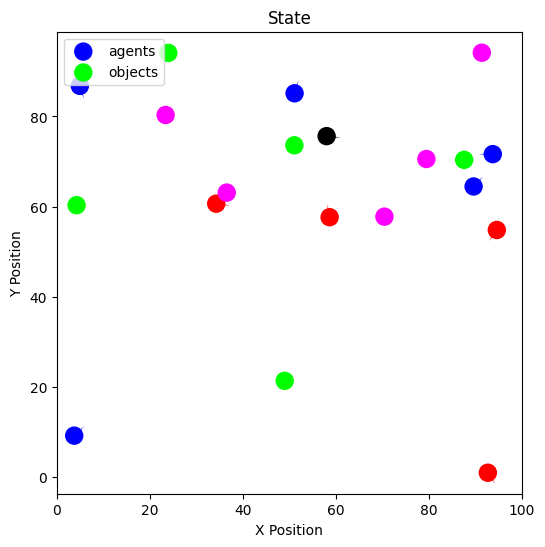

In [44]:
render(state)

In [45]:
env = SelectiveSensorsEnv(state, occlusion=True)

### Autonomous behaviors

In [46]:
n_steps = 10_000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

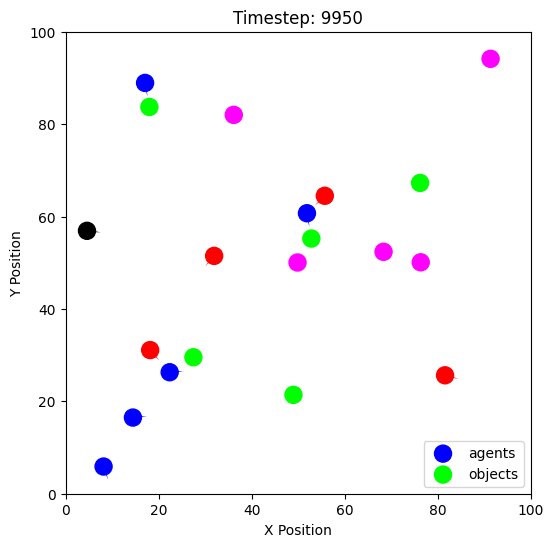

In [47]:
render_history(hist, skip_frames=50)

### Test manual behavior for an agent

Need to set all of its behaviors to manual.

In [48]:
ag_idx = 9
manual_behaviors = jnp.array([Behaviors.MANUAL.value, Behaviors.MANUAL.value,])
manual_color = jnp.array([0., 0., 0.])
manual_motors = jnp.array([1., 1.])

behaviors = state.agents.behavior.at[ag_idx].set(manual_behaviors)
colors = state.agents.color.at[ag_idx].set(manual_color)
motors = state.agents.motor.at[ag_idx].set(manual_motors)

agents = state.agents.replace(behavior=behaviors, color=colors, motor=motors)
state = state.replace(agents=agents)

In [49]:
n_steps = 5_000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

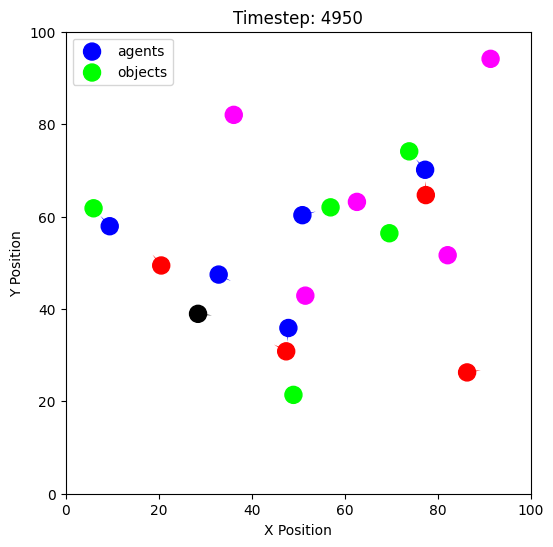

In [50]:
render_history(hist, skip_frames=50)

### Remove occlusion for agents

Doesn't work yet but maybe not really important. In fact even if the function is changed the compiled _step function in the env stays the same. So I could give the compute_all_agents_proxs_motors function as an argument of the _step but I don't know if it is worth it. (Might be the case if we also accept a function for non selective sensing in this environment)

In [51]:
print(f"Before: occlusion={env.occlusion}, function={env.compute_all_agents_proxs_motors}")

env.occlusion = False
env.update_agent_prox_motor_function()
print(f"After: occlusion={env.occlusion}, function={env.compute_all_agents_proxs_motors}")


Before: occlusion=True, function=<function compute_occlusion_proxs_motors at 0x70330f4845e0>
After: occlusion=False, function=<function compute_agent_proxs_motors at 0x70330f484ee0>


In [52]:
n_steps = 10_000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

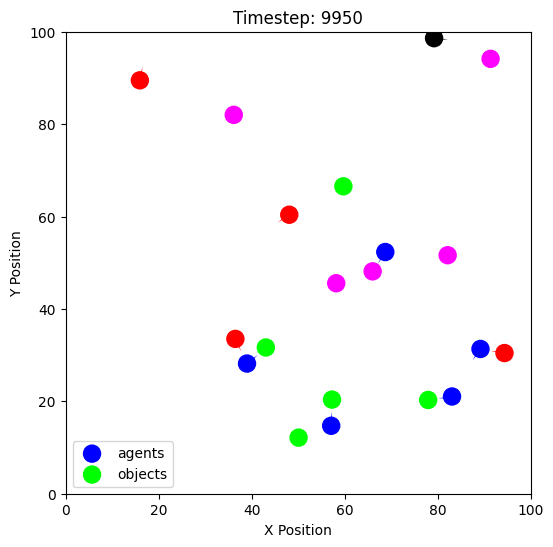

In [53]:
render_history(hist, skip_frames=50)